In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage

import os
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
os.environ["LANGSMITH_PROJECT"] = "TestProject"

In [3]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000213858F69D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021385A42150>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
llm.invoke("define transformers in NLP.")

AIMessage(content='In Natural Language Processing (NLP), transformers are a type of neural network architecture that have revolutionized the field by achieving state-of-the-art results in many tasks, such as machine translation, text classification, and language modeling.\n\nThe transformer architecture was introduced in a paper by Vaswani et al. in 2017, titled "Attention is All You Need". The main idea behind transformers is to abandon the traditional recurrent neural network (RNN) architecture and instead use self-attention mechanisms to process input sequences.\n\nHere are the key components of a transformer:\n\n1. **Self-Attention Mechanism**: This is the core component of the transformer architecture. It allows the model to attend to different parts of the input sequence simultaneously and weigh their importance. This is different from RNNs, which process input sequences sequentially and have a fixed context window.\n2. **Encoder-Decoder Structure**: The transformer consists of a

In [6]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage], add_messages]


In [7]:
## Graph with tool call

@tool
def add(a:float, b:float):
    """Add two numbers"""
    return a+b

tools = [add]
tool_node = ToolNode([add])

llm_with_tool = llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

In [8]:
## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", call_llm_model)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

## compike the graph
graph = builder.compile()

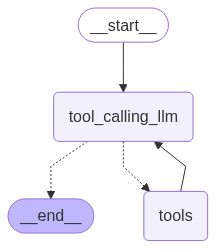

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
response = graph.invoke({"messages": "What is machine learning?"})

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_calls": [\n        {\n            "id": "pending",\n            "type": "function",\n            "function": {\n                "name": "define_machine_learning"\n            },\n            "parameters": {}\n        }\n    ]\n}\n</tool-use>'}}

In [ ]:
type(response)

dict

In [ ]:
type(response["messages"])

list

In [ ]:
response["messages"][-1].content

'Machine learning is a type of artificial intelligence (AI) that enables computers to learn from data without being explicitly programmed. It involves training algorithms on large datasets to recognize patterns, make predictions, and improve their performance over time. Machine learning is widely used in applications such as image and speech recognition, natural language processing, and autonomous vehicles.\n\nMachine learning algorithms can be categorized into three main types:\n\n1. Supervised learning: In this type of learning, the algorithm is trained on labeled data, where the correct output is already known. The algorithm learns to map inputs to outputs based on the labeled data, and can make predictions on new, unseen data.\n2. Unsupervised learning: In this type of learning, the algorithm is trained on unlabeled data, and must find patterns or structure in the data on its own. This type of learning is often used for clustering, dimensionality reduction, and anomaly detection.\n

In [ ]:
response = graph.invoke({"messages": "What is 5 plus 20?"})

In [ ]:
response

{'messages': [HumanMessage(content='What is 5 plus 20?', additional_kwargs={}, response_metadata={}, id='b881bd8d-8b2f-4954-b5d4-8e891732106a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'h46n4m32e', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 899, 'total_tokens': 971, 'completion_time': 0.081718728, 'prompt_time': 0.100140764, 'queue_time': 0.045762932000000006, 'total_time': 0.181859492}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c610ef99-b82f-4868-a7a5-a7a8694404cd-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': 'h46n4m32e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 899, 'output_tokens': 72, 'total_tokens': 971}),
  ToolMessage(content='25.0', name='add', id='22ae744a-f845-47f4-87df-d8add6c3e2bf', tool